/var/folders/8g/vf04_2xx1zn7r_rbs94g3p5m0000gn/T/ipykernel_10988/1924117952.py:150: RuntimeWarning: divide by zero encountered in divide
  Thetas = np.arctan(l_opps[:, None] / beam_d[None, :])  # (n_det, n_d)


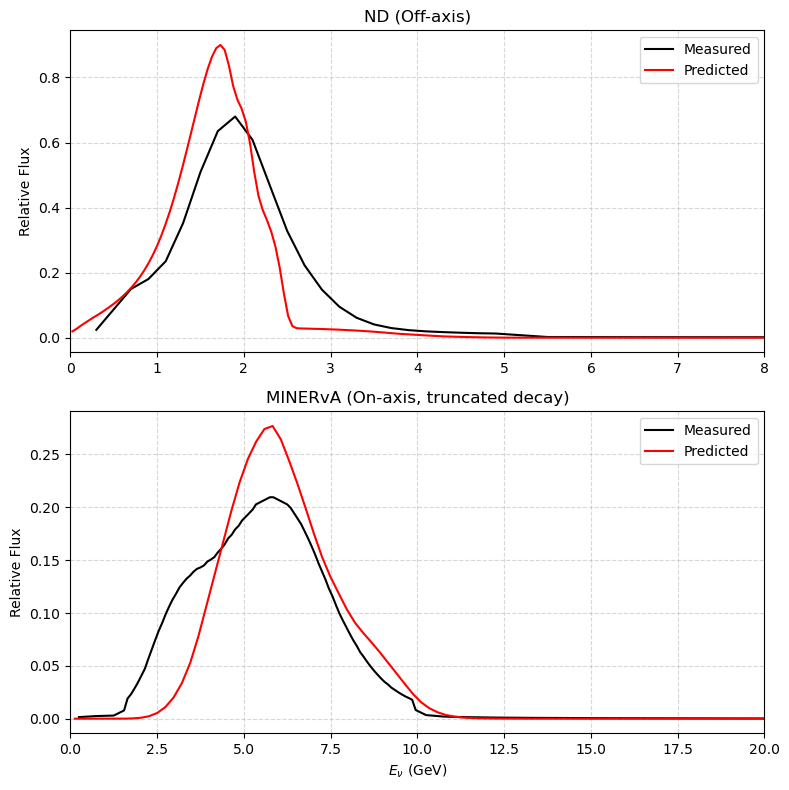

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gamma, norm
import matplotlib.pyplot as plt

# Physical constants
E_STAR = 29.8   # Conversion factor
M_PI = 139.6    # MeV/c^2
TAU_PI = 26.03  # ns (pion rest-frame lifetime)

# ---------------------------
# Utility functions
# ---------------------------

def compute_bin_edges(centers: np.ndarray) -> np.ndarray:
    """
    Compute histogram edges from bin centers.
    """
    widths = np.diff(centers)
    edges = np.empty(len(centers) + 1)
    edges[1:-1] = (centers[:-1] + centers[1:]) / 2
    edges[0]     = centers[0] - widths[0] / 2
    edges[-1]    = centers[-1] + widths[-1] / 2
    return edges


def sample_pion_energy(params: tuple, n_samples: int, seed: int = 42) -> np.ndarray:
    """
    Sample pion energies from a 3-component mixture (gamma + two normals).
    params = (w1_raw, w2_raw, a1, scale1, mu2, sigma2, mu3, sigma3)
    """
    rng = np.random.default_rng(seed)
    w1_raw, w2_raw, a1, scale1, mu2, sigma2, mu3, sigma3 = params
    w1 = w1_raw
    w2 = w2_raw * (1 - w1)
    w3 = 1 - w1 - w2
    n1 = int(w1 * n_samples)
    n2 = int(w2 * n_samples)
    n3 = n_samples - n1 - n2
    s1 = gamma.rvs(a=a1, scale=scale1, size=n1, random_state=rng)
    s2 = norm.rvs(loc=mu2, scale=sigma2, size=n2, random_state=rng)
    s3 = norm.rvs(loc=mu3, scale=sigma3, size=n3, random_state=rng)
    return np.concatenate([s1, s2, s3])


def compute_lab_neutrino_energy(e_pi: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """
    Vectorized lab-frame neutrino energy from pion energies and angles.
    """
    gamma_factor = e_pi * 1000 / M_PI
    return (0.002 * E_STAR * gamma_factor) / (1 + (gamma_factor * theta)**2)


def build_pion_slices(params: tuple,
                       scan_min: float,
                       scan_max: float,
                       slice_width: float) -> np.ndarray:
    """
    Build pion energy slices & weights via mixture CDF differences.
    Returns array of shape (n_s,3): [E_mid, gamma, weight].
    """
    w1_raw, w2_raw, a1, scale1, mu2, sigma2, mu3, sigma3 = params
    w1 = w1_raw
    w2 = w2_raw * (1 - w1)
    w3 = 1 - w1 - w2
    def mixture_cdf(x):
        return (w1 * gamma.cdf(x, a=a1, scale=scale1)
                + w2 * norm.cdf(x, loc=mu2, scale=sigma2)
                + w3 * norm.cdf(x, loc=mu3, scale=sigma3))
    edges = np.arange(scan_min, scan_max + slice_width, slice_width)
    mids = 0.5 * (edges[:-1] + edges[1:])
    weights = mixture_cdf(edges[1:]) - mixture_cdf(edges[:-1])
    gamma_vals = mids * 1000 / M_PI
    #print(np.sum(weights))
    return np.vstack([mids, gamma_vals, weights]).T


def compute_decay_population(pion_slices: np.ndarray, time_steps: np.ndarray) -> np.ndarray:
    """
    Vectorized decay population over time for each slice.
    Returns decay_pop: shape (n_slices, n_times).
    """
    gamma_vals = pion_slices[:,1]       # (n_slices,)
    weights    = pion_slices[:,2]       # (n_slices,)
    t = time_steps[np.newaxis, :]       # (1, n_times)
    G = gamma_vals[:, np.newaxis]       # (n_slices, 1)
    dt = time_steps[1] - time_steps[0]
    exp_t    = np.exp(-t / (G * TAU_PI))
    exp_t_dt = np.exp(-(t - dt) / (G * TAU_PI))
    decay_prob = np.empty_like(exp_t)
    decay_prob[:,0] = 1 - exp_t[:,0]
    decay_prob[:,1:] = exp_t_dt[:,1:] - exp_t[:,1:]
    return decay_prob * weights[:, np.newaxis]


def rebin_time_to_distance(events: np.ndarray, speeds: np.ndarray,
                            dt: float, dd: float):
    """
    Rebin events from time bins to distance bins via CDF interpolation.
    Returns (dist_events, max_distance, n_bins).
    """
    # ensure valid speeds
    speeds = np.clip(speeds, 0, 0.3)
    n_s, n_t = events.shape
    d_mid = speeds[:, None] * ((np.arange(n_t)[None,:] + 0.5) * dt)
    max_d = np.nanmax(d_mid)
    dist_edges = np.arange(0, max_d + dd, dd)
    n_bins = len(dist_edges) - 1
    dist_events = np.zeros((n_s, n_bins))
    for i in range(n_s):
        cum = np.concatenate(([0], np.cumsum(events[i])))
        d_vals = np.concatenate(([0], d_mid[i]))
        F = np.interp(dist_edges, d_vals, cum, left=0, right=cum[-1])
        dist_events[i] = np.diff(F)
    return dist_events, max_d, n_bins

def compute_flux_matrix_onaxis(pion_slices, dist_events, l_adj, dd):
    """
    Simplified flux matrix for on-axis detector (no solid angle correction).
    """
    n_s, n_d = dist_events.shape
    beam_d = l_adj - np.arange(n_d) * dd
    Thetas = np.zeros((1, n_d))  # On-axis ⇒ θ = 0
    E_pi = pion_slices[:, 0]
    G = E_pi * 1000 / M_PI
    G3 = G[None, :, None]
    Th3 = Thetas[:, None, :]
    nu_e_all = (0.002 * E_STAR * G3) / (1 + (G3 * Th3)**2)
    flux_all = dist_events[None, :, :] * nu_e_all
    return nu_e_all, flux_all

def compute_flux_matrix(pion_slices: np.ndarray,
                        dist_events: np.ndarray,
                        l_opps: np.ndarray,
                        l_adj: float,
                        dd: float,
                        det_width: float = 4.0,
                        det_height: float = 4.0) -> (np.ndarray, np.ndarray):
    """
    Compute neutrino energies & flux for each detector, including solid angle correction.
    Returns (nu_e_all, flux_all) of shape (n_det, n_slices, n_dist).
    """
    n_s, n_d = dist_events.shape
    n_det = len(l_opps)
    
    # Beam-aligned distances
    beam_d = l_adj - np.arange(n_d) * dd                   # (n_d,)
    
    # Angles from detector offsets
    Thetas = np.arctan(l_opps[:, None] / beam_d[None, :])  # (n_det, n_d)

    # Pion energy and Lorentz factor
    E_pi = pion_slices[:, 0]                               # (n_s,)
    G = E_pi * 1000 / M_PI                                 # (n_s,)

    # Broadcasted Lorentz and angles
    G3 = G[None, :, None]                                  # (1, n_s, 1)
    Th3 = Thetas[:, None, :]                               # (n_det, 1, n_d)

    # Neutrino energy spectrum
    nu_e_all = (0.002 * E_STAR * G3) / (1 + (G3 * Th3)**2)  # (n_det, n_s, n_d)

    # Apparent solid angle in pion rest frame
    x1 = (beam_d - det_width / 2)[None, None, :]           # (1, 1, n_d)
    x2 = (beam_d + det_width / 2)[None, None, :]           # (1, 1, n_d)
    y1 = (l_opps - det_height / 2)[:, None, None]          # (n_det, 1, 1)
    y2 = (l_opps + det_height / 2)[:, None, None]          # (n_det, 1, 1)

    # Lorentz transform: x' = (x - distance) / gamma
    gamma_vals = G[None, :, None]                          # (1, n_s, 1)
    x1_rest = (x1 - beam_d[None, None, :]) / gamma_vals    # (1, n_s, n_d)
    x2_rest = (x2 - beam_d[None, None, :]) / gamma_vals

    # Expand to (n_det, n_s, n_d)
    x1_rest = np.broadcast_to(x1_rest, (n_det, n_s, n_d))
    x2_rest = np.broadcast_to(x2_rest, (n_det, n_s, n_d))
    y1 = np.broadcast_to(y1, (n_det, n_s, n_d))
    y2 = np.broadcast_to(y2, (n_det, n_s, n_d))

    center_x = (x1_rest + x2_rest) / 2
    center_y = (y1 + y2) / 2
    d = np.sqrt(center_x**2 + center_y**2)
    u_x = center_x / d
    u_y = center_y / d
    v_x = x2_rest - x1_rest
    v_y = y2 - y1
    dot_uv = u_x * v_x + u_y * v_y
    v_proj_x = v_x - dot_uv * u_x
    v_proj_y = v_y - dot_uv * u_y
    width_proj = np.sqrt(v_proj_x**2 + v_proj_y**2)
    area_proj = width_proj * det_height
    solid_angle = area_proj / (d**2)                        # (n_det, n_s, n_d)

    # Apply solid angle correction
    flux_all = dist_events[None, :, :] * nu_e_all * solid_angle  # (n_det, n_s, n_d)
    
    mean_solid_angle = np.mean(solid_angle, axis=2)  # (n_det, n_s)

    return nu_e_all, flux_all, mean_solid_angle


def plot_neutrino_spectrum(fluxes: list,
                           labels: list,
                           nu_energies: list,
                           dataframes: list,
                           titles: list = None,
                           xlims: list = None,
                           fine_bins: int = 500):
    """
    Plot measured vs predicted neutrino flux spectra in separate subplots,
    each with its own independent x-axis scale.
    """
    n = len(fluxes)
    fig, axs = plt.subplots(n, 1, figsize=(8, 4 * n), sharex=False)

    if n == 1:
        axs = [axs]

    for i in range(n):
        df_data = dataframes[i]
        centers = df_data['bin center'].values
        measured_flux = df_data['norm flux'].values

        pred_e = nu_energies[i].flatten()
        pred_w = fluxes[i].flatten()
        assert pred_e.shape == pred_w.shape
        
        # Normalize weights
        pred_w /= np.sum(pred_w)
        
        # Define a fine energy grid
        e_min = min(pred_e.min(), centers.min())
        e_max = max(pred_e.max(), centers.max())
        fine_edges = np.linspace(e_min, e_max, fine_bins + 1)
        fine_centers = 0.5 * (fine_edges[:-1] + fine_edges[1:])
        bin_width = fine_edges[1] - fine_edges[0]
        
        # Histogram on fine grid
        hist, _ = np.histogram(pred_e, bins=fine_edges, weights=pred_w, density=False)
        hist = hist / (np.sum(hist) * bin_width)  # normalize to density
        
        # Optional: smooth it
        from scipy.ndimage import gaussian_filter1d
        hist = gaussian_filter1d(hist, sigma=1.0)

        # Plot measured
        axs[i].plot(centers, measured_flux, 'k-', label='Measured')
        # Plot predicted
        #axs[i].plot(bin_centers, hist, 'r-', label='Predicted')
        axs[i].plot(fine_centers, hist, 'r-', label='Predicted')
        axs[i].set_ylabel('Relative Flux')
        axs[i].legend()
        axs[i].grid(True, which='both', linestyle='--', alpha=0.5)
        axs[i].set_title(titles[i] if titles else labels[i])
        axs[i].set_xlim(e_min, e_max)

        # Set custom x-limits if provided
        if xlims and xlims[i]:
            axs[i].set_xlim(*xlims[i])
        else:
            axs[i].set_xlim(e_min, e_max)
    
        axs[-1].set_xlabel(r'$E_\nu$ (GeV)')
        
    plt.tight_layout()
    plt.show()

# ---------------------------
# Main workflow
# ---------------------------
def main():
    # Load experimental flux data
    df = pd.read_csv('MINERvA_Neutrino_fluxes.csv')
    df2 = pd.read_csv('ND flux data.csv')
    # Process MINERvA
    
    df = df[['Bin center', 'Flux', 'Error']].copy()
    df['bin center']=df['Bin center']

    # Estimate bin widths
    bin_centers = df['Bin center'].values
    bin_edges = compute_bin_edges(bin_centers)
    bin_widths = np.diff(bin_edges)
    
    # Normalize flux to a probability density
    df['bin width'] = bin_widths
    df['flux density'] = df['Flux'] / df['bin width']
    df['norm flux'] = df['flux density'] / (df['flux density'] * df['bin width']).sum()
        
    # Process ND
    df2['bin width'] = df2['emax'] - df2['#emin']
    df2['norm flux'] /= df2['bin width']
    df2['norm flux'] /= (df2['norm flux'] * df2['bin width']).sum()

    # Pion energy sampling
    params =np.array( [ 0.45,  0.97 ,  8.3,  1.1, 10.7, 3.5 , 20,  2.0]) 
    samples = 1000000
    pions = sample_pion_energy(params, samples)

    # Build pion slices & decay populations
    scan_min, scan_max, slice_width = 0.0, 30.0, 0.05
    pion_slices = build_pion_slices(params, scan_min, scan_max, slice_width)
    time_window, time_inc = 10000, 1
    time_steps = np.arange(0, time_window + time_inc, time_inc)
    decay_pop = compute_decay_population(pion_slices, time_steps)

    # Compute speeds (beta*0.3 m/ns), avoid invalid
    gamma_vals = pion_slices[:,1]
    beta = np.sqrt(np.clip(1 - 1/(gamma_vals**2), 0, None))
    speeds = 0.3 * beta

    # Rebin events to distance
    dist_ev, _, _ = rebin_time_to_distance(decay_pop, speeds, dt=1, dd=1)
    
    # Detector geometry
    l_opps = np.array([12.0, 14.0, 16.0])  # Off-axis
    l_adj  = 1000.0                        # Distance from source to detector
    dd = 1.0                               # Distance bin width
    
    # Compute off-axis detector flux (ND)
    nu_e_all, flux_all, solid_angle_avg = compute_flux_matrix(
        pion_slices, dist_ev, l_opps, l_adj, dd
    )
    
    # -------- MINERvA (on-axis) configuration --------
    decay_max_distance = 800.0  # e.g., wall at 800 m
    dist_cutoff_bin = int(decay_max_distance // dd)
    dist_ev_miner = dist_ev[:, -dist_cutoff_bin:]
    
    nu_miner, flux_miner = compute_flux_matrix_onaxis(pion_slices, dist_ev_miner, l_adj, dd)
    
    # Plot results against ND data
    plot_neutrino_spectrum(
        fluxes=[flux_all, flux_miner],
        labels=['ND Off-axis', 'MINERvA On-axis'],
        nu_energies=[nu_e_all, nu_miner],
        dataframes=[df2, df],
        titles=['ND (Off-axis)', 'MINERvA (On-axis, truncated decay)'],
        xlims=[(0, 8), (0, 20)],
        fine_bins=400  # finer grid = smoother curve
    )


if __name__ == '__main__':
    main()



In [29]:
params =np.array( [ 0.35,  0.97 ,  8.3,  1.1, 14.7, 3.5 , 25,  2.0]) 
samples = 500000

pions=sample_pion_energy(params, samples, 42)  #create multi-distribution pion sample
scan_min, scan_max, slice_width = 0.0, 100.0, 0.1
pion_slices = build_pion_slices(params, scan_min, scan_max, slice_width) #create slices for integration
time_window, time_inc = 10000, 1
time_steps = np.arange(0, time_window + time_inc, time_inc)
decay_pop = compute_decay_population(pion_slices, time_steps)

# Compute speeds (beta*0.3 m/ns), avoid invalid
gamma_vals = pion_slices[:,1]
beta = np.sqrt(np.clip(1 - 1/(gamma_vals**2), 0, None))
speeds = 0.3 * beta

# Rebin events to distance
dist_ev, _, _ = rebin_time_to_distance(decay_pop, speeds, dt=1, dd=1)

In [35]:
np.sum(dist_ev[:,:1000])

0.7586429074706008